In [ ]:
import os
import cv2
import torch
import numpy as np
from torch import nn
import matplotlib.cm as cm
from einops import rearrange
import matplotlib.pyplot as plt


from sensorium import data
from sensorium.models.model import Model
from sensorium.models.core.vit import ViTCore, Attention
from sensorium.utils.scheduler import Scheduler

from sensorium.utils import utils, tensorboard, yaml

utils.set_random_seed(1234)

GRAY = cm.get_cmap("gray")
BACKGROUND_COLOR = "#ffffff"

MOUSE_ID = 2

In [ ]:
class Args:
    def __init__(self):
        self.output_dir = "/Users/bryanlimy/Git/sensorium/runs/sensorium+/049_vit_gaussian2d_0.2dropout"
        self.device = torch.device("cpu")
        self.batch_size = 1
        for key, value in yaml.load(os.path.join(self.output_dir, "args.yaml")).items():
            if not hasattr(self, key):
                setattr(self, key, value)
        self.p_dropout = self.dropout
        self.t_dropout = self.dropout
        self.dataset = os.path.join("..", self.dataset)


args = Args()

_, val_ds, _ = data.get_training_ds(
    args,
    data_dir=args.dataset,
    mouse_ids=args.mouse_ids,
    batch_size=args.batch_size,
    device=args.device,
)

model = Model(args, ds=val_ds)
model.train(False)

scheduler = Scheduler(args, model=model, save_optimizer=False)
scheduler.restore(force=True)

In [ ]:
class Recorder(nn.Module):
    def __init__(self, vit: ViTCore, device: str = "cpu"):
        super().__init__()
        self.vit = vit

        self.data = None
        self.recordings = []
        self.hooks = []
        self.hook_registered = False
        self.ejected = False
        self.device = device

    def _hook(self, _, input, output):
        self.recordings.append(output.clone().detach())

    @staticmethod
    def _find_modules(nn_module, type):
        return [module for module in nn_module.modules() if isinstance(module, type)]

    def _register_hook(self):
        modules = self._find_modules(self.vit.transformer, Attention)
        for module in modules:
            handle = module.attend.register_forward_hook(self._hook)
            self.hooks.append(handle)
        self.hook_registered = True

    def eject(self):
        self.ejected = True
        for hook in self.hooks:
            hook.remove()
        self.hooks.clear()
        return self.vit

    def clear(self):
        self.recordings.clear()

    def record(self, attn):
        recording = attn.clone().detach()
        self.recordings.append(recording)

    def forward(self, images: torch.Tensor, behaviors: torch.Tensor):
        assert not self.ejected, "recorder has been ejected, cannot be used anymore"
        self.clear()
        if not self.hook_registered:
            self._register_hook()
        pred = self.vit(inputs=images, behaviors=behaviors)
        recordings = tuple(map(lambda t: t.to(self.device), self.recordings))
        attns = torch.stack(recordings, dim=1) if len(recordings) > 0 else None
        return pred, attns

In [ ]:
def plot_attention_map(image: np.ndarray, attention: np.ndarray):
    figure, axes = plt.subplots(
        nrows=1,
        ncols=2,
        figsize=(8, 3),
        gridspec_kw={"wspace": 0.03, "hspace": 0.1},
        dpi=120,
        facecolor=BACKGROUND_COLOR,
    )
    axes[0].imshow(image[0], cmap="gray")
    axes[0].set_title("Input")
    axes[1].imshow(attention[0], cmap="inferno")
    axes[1].set_title("Attention rollout")
    for ax in axes:
        tensorboard.remove_spines(ax)
        ax.set_xticks([])
        ax.set_yticks([])

    # plot colorbar
    pos = axes[1].get_position()
    width, height = 0.01, pos.y1 * 0.3
    cbar_ax = figure.add_axes(
        rect=[
            pos.x1 + 0.01,
            ((pos.y1 - pos.y0) / 2 + pos.y0) - (height / 2),
            width,
            height,
        ]
    )
    figure.colorbar(cm.ScalarMappable(cmap="inferno"), cax=cbar_ax, shrink=0.1)
    tensorboard.set_yticks(
        axis=cbar_ax,
        ticks_loc=np.linspace(0, 1, 3),
        tick_fontsize=8,
    )
    tensorboard.set_ticks_params(axis=cbar_ax)
    plt.show()

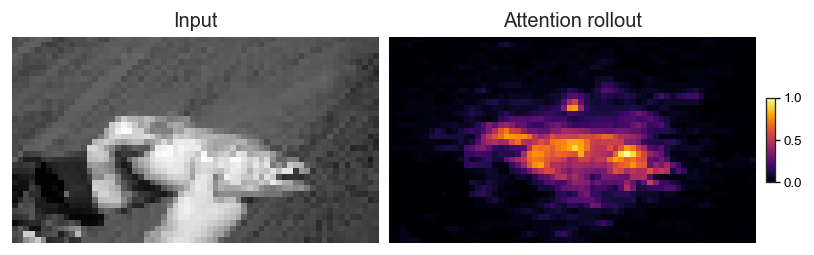

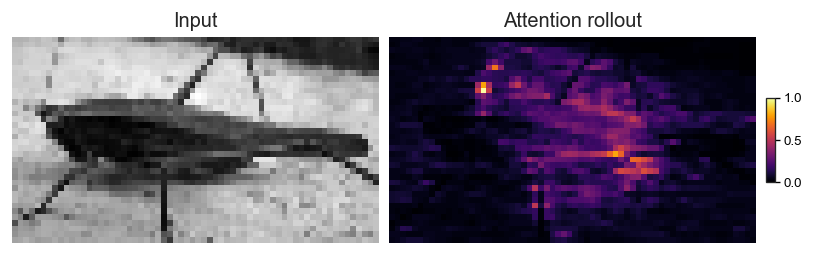

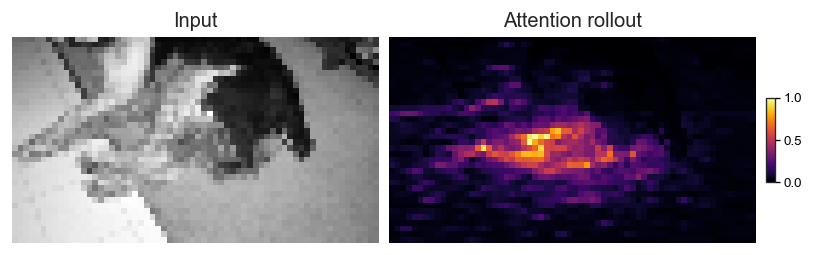

In [29]:
recorder = Recorder(model.core)
i = 0
for batch in val_ds[MOUSE_ID]:
    images, behaviors, pupil_centers = (
        batch["image"],
        batch["behavior"],
        batch["pupil_center"],
    )
    images, _ = model.image_cropper(
        inputs=images,
        mouse_id=MOUSE_ID,
        pupil_centers=pupil_centers,
        behaviors=behaviors,
    )
    _, attns = recorder(images=images, behaviors=behaviors)

    images = val_ds[MOUSE_ID].dataset.i_transform_image(images)
    image = images.numpy()[0]
    # attns.shape = (batch x layers x heads x patch x patch)
    attns = attns[0]
    attns = torch.mean(attns, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(attns.size(1))
    aug_att_mat = attns + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n - 1])

    v = joint_attentions[-1]
    mask = v[0, 1:].reshape(33, 61).numpy()
    mask = mask / mask.max()
    mask = cv2.resize(mask, image.shape[1:])
    mask = rearrange(mask, "w h -> 1 h w")
    heatmap = mask * image
    plot_attention_map(image=image, attention=heatmap.astype("uint8"))
    i += 1
    if i > 2:
        break